In [1]:
import pandas as pd
df_peso = pd.read_stata(r'C:\Users\vimed\Downloads\banco_ISA_Vinicius (1).dta')

df = pd.read_csv(r'C:\Users\vimed\Downloads\Data_Set_para_Contrafactuais.csv')

df = df.merge(df_peso,right_on='id_original', left_on='id', how='inner')

In [2]:
import pandas as pd
import numpy as np

df = df.copy()

cols_km = ['AFTOTAL2', 'AFTOTAL1', 'km2015', 'km2016', 'km2017', 'km2018', 'km2019', 'km2020']
# conversao para dados numericos e dados invalidos para Nan, como tratativa de erro
df[cols_km] = df[cols_km].apply(pd.to_numeric, errors='coerce')

# Análise da evolução anual das ciclovias
print("EVOLUÇÃO ANUAL DAS CICLOVIAS")

# Lista das colunas selecionadas
anos_km = ['km2015', 'km2016', 'km2017', 'km2018', 'km2019', 'km2020']
# Calculo do aumento medio anual entre os anos
aumentos_anuais = [(df[anos_km[i]] - df[anos_km[i-1]]).mean() for i in range(1, len(anos_km))]
# mostrar o aumento a acada ano
for i, aumento in enumerate(aumentos_anuais, start=1):
    print(f"{anos_km[i-1][2:]}→{anos_km[i][2:]}: +{aumento:.3f} km")

print(f"\nAumento médio anual (2015-2020): {np.mean(aumentos_anuais):.3f} km/ano")


EVOLUÇÃO ANUAL DAS CICLOVIAS
2015→2016: +0.170 km
2016→2017: +0.001 km
2017→2018: +0.000 km
2018→2019: +0.033 km
2019→2020: +0.158 km

Aumento médio anual (2015-2020): 0.072 km/ano


In [3]:
import numpy as np
import statsmodels.api as sm
import pandas as pd


df = df.copy()
# Colunas selecionadas
cols_num = ['AFTOTAL2', 'AFTOTAL1', 'km2015', 'km2020']
# conversão ds dados da colunas para numericos
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors='coerce')

# Cálculo de diferenças de minutos de atividade fisica entre os dois periodos
df['Delta_minutos'] = df['AFTOTAL2'] - df['AFTOTAL1']
# calculo das diferenças de quilometros entre 2015 e 2020
df['Delta_km'] = df['km2020'] - df['km2015']
# mantendo as observações reais na quilometragem,filtra numeros diferentes de Zero
df_valido = df[df['Delta_km'] != 0]

# Variavel dependente : mudança nos minutos
y_diferenca = df_valido['Delta_minutos']
# variável independente: mudança nas kilometragens
X_diferenca = sm.add_constant(df_valido[['Delta_km']])
# uso do modelo da biblioteca de revisao
model_diferenca = sm.OLS(y_diferenca, X_diferenca).fit()
beta1 = model_diferenca.params['Delta_km']

# Efeitos anuais
num_anos =5
# media da expsão por ciclovia
expansao_media_real = df_valido['Delta_km'].mean()

print("Efeitos anuais")
# conversão do efeito total para médio
print(f"Efeito anual por km: {beta1/num_anos:.2f} minutos/semana/ano/km")

# Cenários contrafactuais
fatores = [1.25, 1.5, 1.75, 2.0] # fatores de aumento anuais da expansão
for fator in fatores:
    expansao = expansao_media_real * fator  # ajuste da expansão
    impacto_anual = (beta1 * expansao) / num_anos # impacto anual estimado
    print(f"Expansão {int((fator-1)*100)}% maior: {impacto_anual:.2f} minutos/semana/ano")

Efeitos anuais
Efeito anual por km: 36.91 minutos/semana/ano/km
Expansão 25% maior: 53.72 minutos/semana/ano
Expansão 50% maior: 64.47 minutos/semana/ano
Expansão 75% maior: 75.21 minutos/semana/ano
Expansão 100% maior: 85.96 minutos/semana/ano


# Transição de Nivel de Atividade Física

In [4]:
def remover_datas_invalidas(df, coluna="datanasc"):
    # conversao  para datetime da biblioteca, em caso de incorreto, colocar NAT
    df[coluna] = pd.to_datetime(df[coluna], dayfirst=True, errors='coerce')
    # desconsiderar as linhas com datas invalidas
    df = df.dropna(subset=[coluna]).reset_index(drop=True)

    return df
df = remover_datas_invalidas(df)
df['datanasc']

0     1957-03-11
1     1959-07-04
2     1983-11-15
3     1973-03-28
4     1998-04-04
         ...    
762   1950-06-14
763   1979-03-10
764   1968-08-11
765   1955-05-08
766   1943-01-03
Name: datanasc, Length: 767, dtype: datetime64[ns]

In [5]:

import pandas as pd
import matplotlib.pyplot as plt

anos = range(2015, 2021) # Periodo estudado
# Impacto em minutos para cada cenário
impacto_progressivo_por_km_ano_CF2 = 53.72
impacto_progressivo_por_km_ano_CF3 =64.47
impacto_progressivo_por_km_ano_CF4 =75.21
impacto_progressivo_por_km_ano_CF5 =85.96

# Mapeamento para a classificação dos fatores de atividade fisica
mapa_fatores = {
    "Sedentário": 1.2,
    "Pouco Ativo": 1.35,
    "Moderadamente Ativo": 1.55,
    "Ativo": 1.72,
    "Extremamente Ativo": 1.9
}
# classificação dos individuos  de acordo com os minutos de atividade
def classificar_atividade(minutos):
    try:
        val = float(minutos)
    except:
        return "Sedentário"
    if val <= 0:
        return "Sedentário"
    elif val < 150:
        return "Pouco Ativo"
    elif val < 300:
        return "Moderadamente Ativo"
    elif val < 450:
        return "Ativo"
    else:
        return "Extremamente Ativo"

# criação de colunas no dataframe com os cenários contrafactual especifico,
def g_contrafactual_cenario(df, cenario):
    coluna_2015 = 'AFTOTAL1' # uso de base os minutos de 2015
    df[f'minutos_{cenario}_2015_base'] = df[coluna_2015]

    for ano in anos:
        # Definir estados e cenários
        if cenario == 'CF1':
            efeito = 0 # Ou seja,  considerar que nao ouve nenhum aumento na quilometragem das ciclovias
        elif cenario == 'CF2':
            efeito = impacto_progressivo_por_km_ano_CF2 * (ano - 2015 + 1)
        elif cenario == 'CF3':
            efeito =  impacto_progressivo_por_km_ano_CF3 * (ano - 2015 + 1)
        elif cenario == 'CF4':
            efeito =  impacto_progressivo_por_km_ano_CF4 * (ano - 2015 + 1)
        elif cenario == 'CF5':
            efeito = impacto_progressivo_por_km_ano_CF5 * (ano - 2015 + 1)
        else:
            efeito = 0

        # Coluna de minutos ajustados, nao podendo passar de zero
        df[f'minutos_{cenario}_{ano}'] = (df[coluna_2015] + efeito).clip(lower=0)

        # Coluna de classificação dos minutos em atividade fisica
        df[f'classificacao_{cenario}_{ano}'] = df[f'minutos_{cenario}_{ano}'].apply(classificar_atividade)

        # Coluna de fator de atividade física
        df[f'Fator_Classificacao_Atividade_{cenario}_{ano}'] = df[f'classificacao_{cenario}_{ano}'].map(mapa_fatores)

    # Colunas base de 2015
    df[f'classificacao_{cenario}_2015_base'] = df[coluna_2015].apply(classificar_atividade)
    df[f'Fator_Classificacao_Atividade_{cenario}_2015_base'] = df[f'classificacao_{cenario}_2015_base'].map(mapa_fatores)

    return df

# # aplicação para cada cenário
for cenario in ['CF1', 'CF2', 'CF3', 'CF4', 'CF5']:
    df = g_contrafactual_cenario(df, cenario)


C:\Users\vimed\AppData\Local\Temp\ipykernel_57036\2458132889.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'classificacao_{cenario}_{ano}'] = df[f'minutos_{cenario}_{ano}'].apply(classificar_atividade)
C:\Users\vimed\AppData\Local\Temp\ipykernel_57036\2458132889.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Fator_Classificacao_Atividade_{cenario}_{ano}'] = df[f'classificacao_{cenario}_{ano}'].map(mapa_fatores)
C:\Users\vimed\AppData\Local\Temp\ipykernel_57036\2458132889.py:57: PerformanceWarning: DataFrame

In [6]:
!pip install adjustText



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


15 [-0.87252653  0.39324224]
22 [ 0.52264103 -0.39608446]


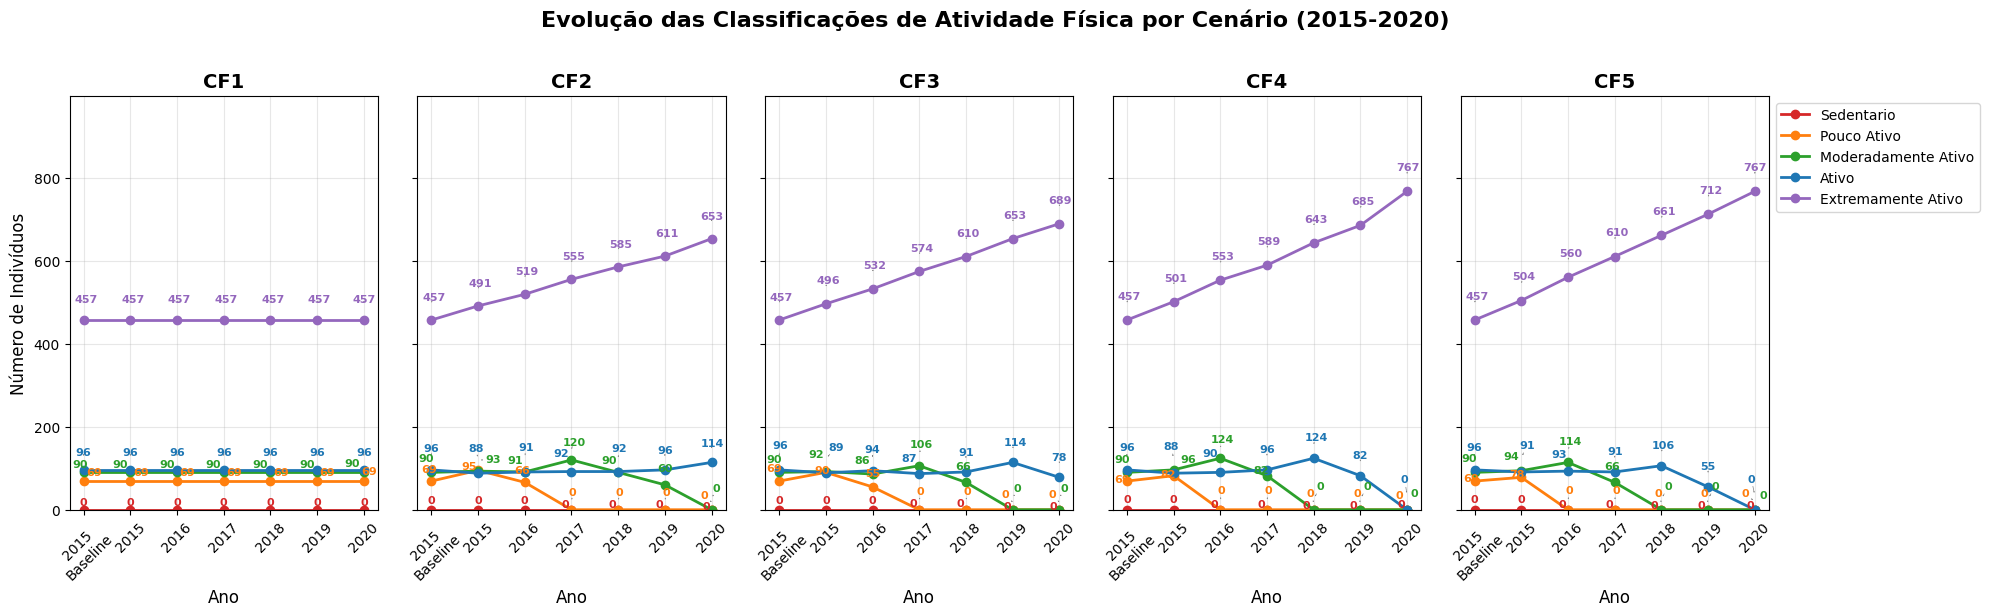

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text  

# Definição das Constantes que serão utilizadas
#Classificação em Nivel de Atividade Fisica
CATEGORIAS = ["Sedentario", "Pouco Ativo", "Moderadamente Ativo", "Ativo", "Extremamente Ativo"]
#Cenários comparativos
CENARIOS = ['CF1', 'CF2', 'CF3', 'CF4', 'CF5']
#Anos  de analise
ANOS = ['2015(base)', '2015', '2016', '2017', '2018', '2019', '2020']
#cores fixas por categorias
CORES = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd'] # cores para cada categoria
## Processamento e calculo das distribuições via classificacao de atividade fisica por ano
# e por cenario
def processar_dados_atividade_fisica(df):
    distrib = {}
    for cenario in CENARIOS:
        contagem_por_ano = {}
        for ano in ANOS:
            col = f"classificacao_{cenario}_{ano.replace('(base)', '_base')}" if 'base' in ano else f"classificacao_{cenario}_{ano}"
            if col in df.columns:
                cont = df[col].value_counts().reindex(CATEGORIAS, fill_value=0)
                contagem_por_ano[ano] = cont
            else:
                print(f" Coluna {col}  encontrada")
        distrib[cenario] = {'contagem': pd.DataFrame(contagem_por_ano)}
    return distrib
# funcao das evoluções de classificações de Atividade Fisica(Exibe)
def plot_distribuicoes_cenarios(distrib):
    anos_str = [a.replace("2015(base)", "2015\nBaseline") for a in ANOS]
    fig, axes = plt.subplots(1, len(CENARIOS), figsize=(20, 6), sharey=True)

    for ax, cenario in zip(axes, CENARIOS):
        cont = distrib[cenario]['contagem']
        textos = []
        for idx, cat in enumerate(CATEGORIAS):
            valores = cont.loc[cat] if cat in cont.index else [0]*len(ANOS)
            #plotagem para cada categoria em linha
            ax.plot(anos_str, valores, marker='o', label=cat, color=CORES[idx], linewidth=2, markersize=6)
           #coloquei os numeros emcima dos pontos
            for x, y in zip(anos_str, valores):
                textos.append(ax.text(x, y+10+idx*8, str(int(y)), fontsize=8, ha='center', va='bottom', color=CORES[idx], weight='bold'))
        ax.set_title(cenario, fontsize=14, fontweight='bold')
        #Estrutura do visual plot
        ax.set_xlabel('Ano', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, cont.values.max() * 1.3)
        adjust_text(textos, ax=ax, only_move={'ponto':'y', 'texto':'y'}, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
# Legendas dos gráficos
    axes[0].set_ylabel('Número de Indivíduos', fontsize=12)
    axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.suptitle('Evolução das Classificações de Atividade Física por Cenário (2015-2020)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# chamada das funções
distrib = processar_dados_atividade_fisica(df)
plot_distribuicoes_cenarios(distrib) #



# Simulação

In [8]:
import pandas as pd
# importar o dataframe de calorias
df_calorias = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Tabela Auxiliar_Consumo Caloric',
    engine='openpyxl'
)
## Excluir Colunas desnecessárias
df_calorias.drop(columns=[
    'Coluna1',
    'Coluna2',
    'Unnamed: 4',
    'Unnamed: 5',
    'Unnamed: 6',
    'Unnamed: 7',
    'Chavemento pof',
    'Kcal-dia.1'
], inplace=True)

df_calorias

,Chavemento pof e ISA,Kcal-dia
0,M|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,1306.500
1,M|Jovens e Adolescentes|Outros|Renda Média-Bai...,829.630
2,M|Adultos|Outros|Renda Média-Baixa|Até Ensino ...,1455.890
3,F|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,2636.490
4,M|Adultos|Branca|Renda Média|Ensino Médio e Su...,1420.615
...,...,...
2357,M|Adultos|Outros|Renda Não Declarada|Até Ensin...,1161.565
2358,M|Adultos|Branca|Renda Não Declarada|Ensino Mé...,2029.671
2359,M|Adultos|Branca|Renda Não Declarada|Até Ensin...,2046.021
2360,F|Idosos|Outros|Renda Média|Até Ensino Fundame...,816.652


In [9]:
df_original = df.copy()

In [10]:
import torch
import numpy as np
import pandas as pd
import random
import warnings

## Padrão de Reprodubilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Conversão das datas  (Formato brasil-EUA), para padronização
def converter_data_brasil_ou_americano(data):
    if pd.isna(data):
        return pd.NaT
    if isinstance(data, (pd.Timestamp, pd.DatetimeTZDtype)):
        return data
    if isinstance(data, str):
        data = data.strip()
        if data == '':
            return pd.NaT
    try:
        return pd.to_datetime(data, format='%d/%m/%Y', errors='raise')
    except Exception:
        try:
            return pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        except Exception:
            warnings.warn(f"Não  converter a  data: {data}.")
            return pd.NaT

############################################################################################################
# Função de Simulação do Torch 
# Esta função usa os parametros do dataframe original , o dataframe de calorias,
# cenarios contrafactuais, numero de semanas da simulação e numero de simulações
# Utilizacao do Metodo de Listagem dos resultados para cada cenarios
def executar_simulacao_torch_cf(df_original, df_calorias, cenario, num_semanas, num_simulacoes):
    # faz um copia do dataframe oficial
    df = df_original.copy().reset_index(drop=True)

    # Converter datas
    df['datanasc'] = df['datanasc'].apply(converter_data_brasil_ou_americano)

    # Colunas  necessárias para uso
    obrigatorias = ['peso', 'datanasc', 'sexo', 'altura', 'id', 'Categorias']
    for c in obrigatorias:
        if c not in df.columns:
            raise ValueError(f"Coluna faltando: {c}")

    # Anos da simulação
    anos = list(range(2015, 2021))

    # Mapeamento de fatores por ano do cenário
    fatores_por_ano = {ano: f'Fator_Classificacao_Atividade_{cenario}_{ano}' for ano in anos}

    # Construir dicionário de fatores por categoria e ano, por meio de um dicionario
    fatores_por_cat_ano = {}
    categorias = df['Categorias'].unique()
    for cat in categorias:
        for ano in anos:
            col_fator = fatores_por_ano[ano]
            if col_fator in df.columns:
                valores = df.loc[(df['Categorias']==cat) & (df[col_fator].notna()), col_fator].unique()
                fatores_por_cat_ano[(cat, ano)] = valores.astype(np.float32) if len(valores) > 0 else np.array([1.2], dtype=np.float32)
            else:
                fatores_por_cat_ano[(cat, ano)] = np.array([1.2], dtype=np.float32)

    # Preparar tensores base relacionado(id, peso, altura, sexo, data de nascimento)
    n = len(df)
    ids = df['id'].values
    peso_t = torch.tensor(df['peso'].astype(float).values.astype(np.float32)) 
    altura_t = torch.tensor(df['altura'].astype(float).values.astype(np.float32)) 
    sexo_t = torch.tensor((df['sexo'].astype(str) == 'M').astype(np.float32).values)
    dias_nascimento_t = torch.tensor(df['datanasc'].dt.normalize().values.astype('datetime64[D]').astype('int64'))

    categorias_array, idx_categorias = np.unique(df['Categorias'].values, return_inverse=True)
    idx_categorias_t = torch.tensor(idx_categorias.astype(np.int64), dtype=torch.long)
    num_categorias = len(categorias_array)

    # Calorias por categoria
    cat_para_valores = {}
    for cat in categorias_array:
        vals = df_calorias.loc[df_calorias['Chavemento pof e ISA'] == cat, 'Kcal-dia'].dropna().astype(float).values.astype(np.float32)
        cat_para_valores[cat] = vals  # Armazena o vetor das calorias diárias dessa categoria no dicionário.

    concat_valores = np.concatenate([cat_para_valores[cat] for cat in categorias_array])
    indices_categorias = {}
    indice_inicio = 0
    for cat in categorias_array:
        indice_fim = indice_inicio + len(cat_para_valores[cat])
        indices_categorias[cat] = (indice_inicio, indice_fim)
        indice_inicio = indice_fim
    concat_valores_t = torch.tensor(concat_valores, dtype=torch.float32)

    # Data de Input de Inicio da Simulação 
    data_base = np.datetime64('2015-01-01').astype('datetime64[D]').astype('int64')

    ## Armazenamento da simulação
    resultados = []

    def semana_para_ano_idx(semana):
        # conversão do número da semana da simulação em um índice de ano
        return min(semana // 52, len(anos)-1)

    # Loop de simulação
    for sim in range(num_simulacoes):
        peso_atual = peso_t.clone()
        balanco_semanal = torch.empty((n, num_semanas), dtype=torch.float32)

        # Interação das semanas para acompanhar a evolução anual/semanal do peso
        for semana in range(num_semanas):
            dia_atual = data_base + semana*7
            idade = ((dia_atual - dias_nascimento_t)//365).to(torch.float32)
            ano_idx = semana_para_ano_idx(semana)
            ano = anos[ano_idx]

            # Fator de atividade por categoria dos indivíduos e ano, sorteio
            fator_sorteado = torch.zeros(n)
        
            for i, cat in enumerate(categorias_array):
                indices_cat = (idx_categorias_t == i).nonzero(as_tuple=True)[0]
                if len(indices_cat) > 0:
                    vals = fatores_por_cat_ano.get((cat, ano), [1.2])
                    vals_t = torch.tensor(vals, dtype=torch.float32)
                    indices = torch.randint(0, len(vals_t), (len(indices_cat),))
                    fator_sorteado[indices_cat] = vals_t[indices]

            # TMB e gasto energético baseado no St. Miffins
            tmb_diaria = (10*peso_atual) + (6.25*altura_t*100) - (5*idade) + (5*sexo_t) + (-161*(1-sexo_t))
            gasto_semanal = tmb_diaria * 7 * fator_sorteado

            # Consumo alimentar apenas os valores de calorias existentes por categoria
            inicio_cat = torch.tensor([indices_categorias[cat][0] for cat in categorias_array], dtype=torch.long)
            fim_cat = torch.tensor([indices_categorias[cat][1] for cat in categorias_array], dtype=torch.long)
            tamanhos = (fim_cat - inicio_cat).to(torch.long)
            rand_rel_7 = torch.floor(torch.rand((n,7)) * tamanhos[idx_categorias_t].unsqueeze(1).to(torch.float32)).to(torch.long)
            idxs = inicio_cat[idx_categorias_t].unsqueeze(1) + rand_rel_7
            consumo_diario = torch.clamp(concat_valores_t[idxs], min=800.0, max=5000.0)
            consumo_semanal = consumo_diario.sum(dim=1)

            # Balanço energético
            balanco = consumo_semanal - gasto_semanal
            # Estabelecimento do Limite inferior do peso com base no estado atual(na semana do individuo em porcentagem) e suavizacao
            limite_deficit = peso_atual * 0.008 * 7700 * (0.92 ** min(semana,40))
            #Estabelecimento do Limite Superior do peso com base no estado atual(na semana do indiv
            limite_superavit = peso_atual * 0.02 * 7700 * (0.92 ** min(semana,40))
                        # Clipagem via limites aceitaveis adotados

            balanco = torch.clamp(balanco, min=-limite_deficit, max=limite_superavit)
            balanco_semanal[:, semana] = balanco
             # Calculo do Peso do Individuo em determinanda semana.
            peso_atual = peso_atual + (balanco/7700)

        # movimentar os dados dO Tensor flow para cpu(caso estejam na GPU) e converter para numpy
        balanco_cpu = balanco_semanal.detach().cpu().numpy()
         # criacao do dataframe  com cada coluna representando o balanço energetico por semana
        df_balanco = pd.DataFrame(balanco_cpu, columns=[f'semana_{i+1}' for i in range(num_semanas)])
         # adicionar cada id para identificar o individuo da simulacao
        df_balanco['id'] = ids
        # enumeracao  do numero da simulacao
        df_balanco['simulacao'] = sim+1
        #Adicionar os cenarios determinados
        df_balanco['cenario'] = cenario
        # armazenamento do dataframe  atual na lista de resutlados
        resultados.append(df_balanco)

    return resultados  

## Função geral para a chamada de função
cenarios = ['CF1','CF2','CF3','CF4','CF5']
resultados_cenarios = {}

for cenario in cenarios:
    # realização da simulacao para cada cenário
    res = executar_simulacao_torch_cf(df_original, df_calorias, cenario, num_semanas=314, num_simulacoes=2)
    resultados_cenarios[cenario] = res

print("Feito simulação para todos os cenários")


Feito simulação para todos os cenários


# Pós-Processamento

In [11]:
import pandas as pd

semanas_por_ano = 52
anos = list(range(2015, 2021)) # intervalo em anos do periodo analisado

# calculo dos contrafactuais ao longo do ano
def calcular_peso_ano(df_sim, df_peso, anos, semanas_por_ano):
    pesos = {}
    # colunas relacionados as semanas acumuladas
    for i, ano in enumerate(anos, start=1):
        colunas = [f'semana_{j+1}' for j in range(i * semanas_por_ano)]
        # calculo do peso medio por pessoa ao longo das semanas
        acumulado = df_sim.groupby('id')[colunas].mean().sum(axis=1)
        # calculo do peso final : produto do peso inicial + a variação/7700kg( 1kg)
        pesos[ano] = df_peso.set_index('id')['peso'] + acumulado / 7700
    return pesos

# funcao para o calculo do imc e peso
def f_contrafactual(df_original, df_sim, anos):
    # dataframe com altura e peso unicas por pessoa
    df_peso = df_original[['id', 'peso', 'altura']].drop_duplicates()
    # calculo do peso por ano
    pesos_por_ano = calcular_peso_ano(df_sim, df_peso, anos, semanas_por_ano)

    df_final = df_original[['id', 'Categorias', 'altura']].drop_duplicates().set_index('id')
    # adiciona a coluna do peso base de inicio da simulacao 
    df_final['Peso_2015_base'] = df_peso.set_index('id')['peso']
    # adiciona  a coluna do imc base de inicio de simulacao 
    df_final['IMC_2015_base'] = df_final['Peso_2015_base'] / (df_final['altura']**2)
    # loop dos anos para interar as colunas de peso  e imc 
    for ano in anos:
        df_final[f'Peso_{ano}_contrafactual'] = pesos_por_ano[ano]
        # calculo do IMC com base na altura e no Peso em cada ano
        df_final[f'IMC_{ano}_contrafactual'] = df_final[f'Peso_{ano}_contrafactual'] / (df_final['altura']**2)

    return df_final.reset_index()

# Pós-processamento para cada simulacao
resultados_cenarios_df = {c: f_contrafactual(df_original, pd.concat(res_list, ignore_index=True), anos)
                          for c, res_list in resultados_cenarios.items()}

# funcao para estatstistas descritivas
def formatar_estatisticas(df, tipo, anos):
    dados = {'Estatística': df[f'{tipo}_2015_base'].describe().index.tolist() + ['n_pessoas']}
    dados[f'{tipo}_2015_base'] = df[f'{tipo}_2015_base'].describe().values.tolist() + [df[f'{tipo}_2015_base'].count()]
    for ano in anos:
        col = f'{tipo}_{ano}_contrafactual'
        desc = df[col].describe()
        dados[col] = desc.values.tolist() + [df[col].count()]
    return pd.DataFrame(dados).round(2)

for cenario, df_final in resultados_cenarios_df.items():
   
    print(f"Estatistica - Cenário {cenario}")
    print("\n--- Peso ---")
    print(formatar_estatisticas(df_final, 'Peso', anos).to_string(index=False))
    print("\n--- IMC ---")
    print(formatar_estatisticas(df_final, 'IMC', anos).to_string(index=False))

    ultimo_ano = anos[-1]
    for tipo in ['Peso', 'IMC']:
        desc = df_final[f'{tipo}_{ultimo_ano}_contrafactual'].describe()
        df_final_df = pd.DataFrame({
            'Estatística': desc.index.tolist() + ['n_pessoas'],
            'Valor': desc.values.tolist() + [df_final[f'{tipo}_{ultimo_ano}_contrafactual'].count()]
        }).round(2)
        print(f"\n--- {tipo} Final {ultimo_ano} ---")
        print(df_final_df.to_string(index=False))
    print("="*50) # separação entre os cenarios, meramente estetico


Estatistica - Cenário CF1

--- Peso ---
Estatística  Peso_2015_base  Peso_2015_contrafactual  Peso_2016_contrafactual  Peso_2017_contrafactual  Peso_2018_contrafactual  Peso_2019_contrafactual  Peso_2020_contrafactual
      count          767.00                   767.00                   767.00                   767.00                   767.00                   767.00                   767.00
       mean           70.75                    66.89                    66.50                    66.13                    65.78                    65.45                    65.14
        std           15.75                    13.31                    12.96                    12.62                    12.31                    12.02                    11.75
        min           34.00                    34.85                    34.53                    34.23                    34.01                    33.69                    33.44
        25%           60.00                    57.49                  

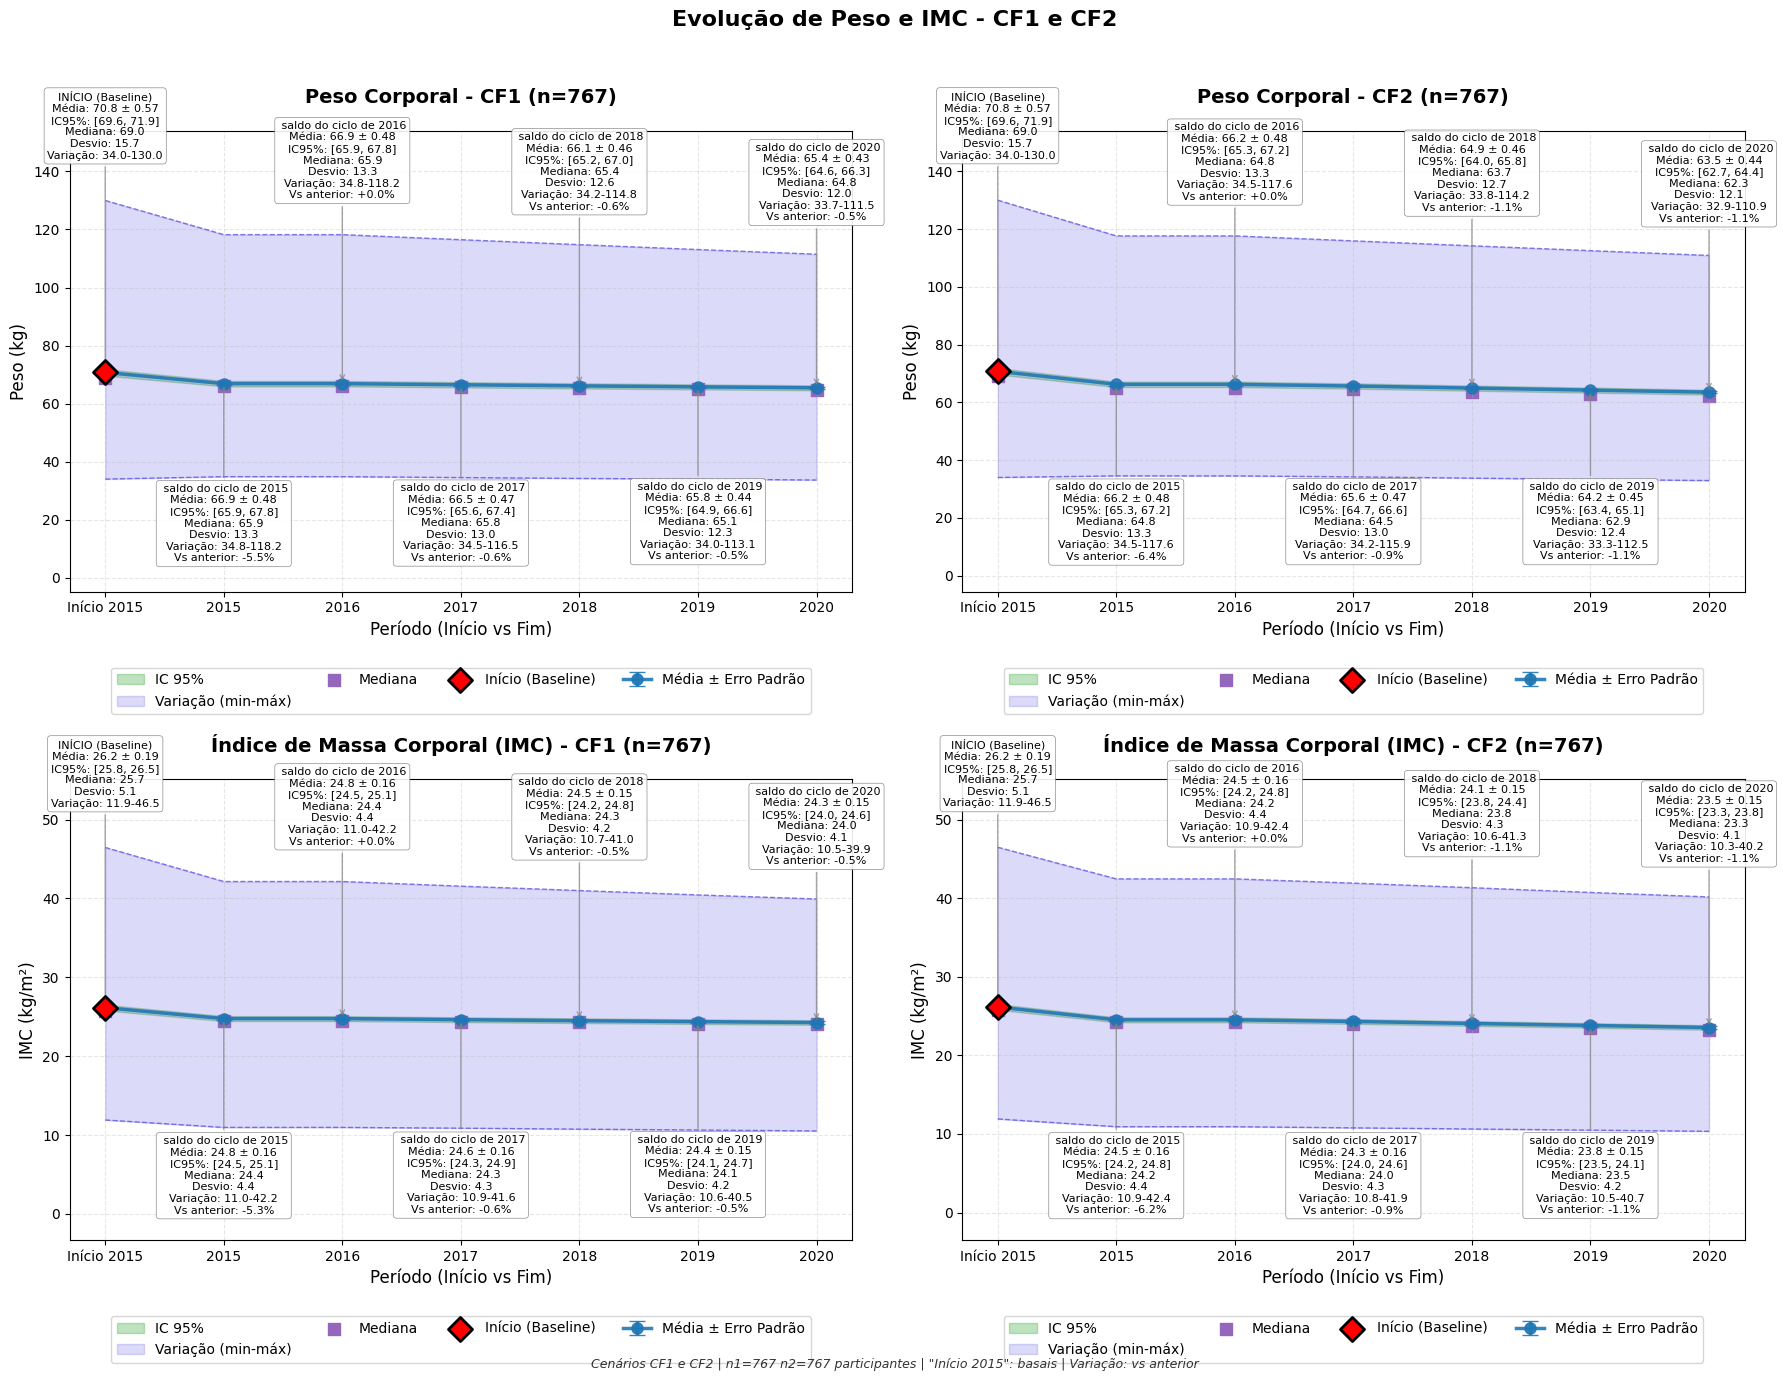

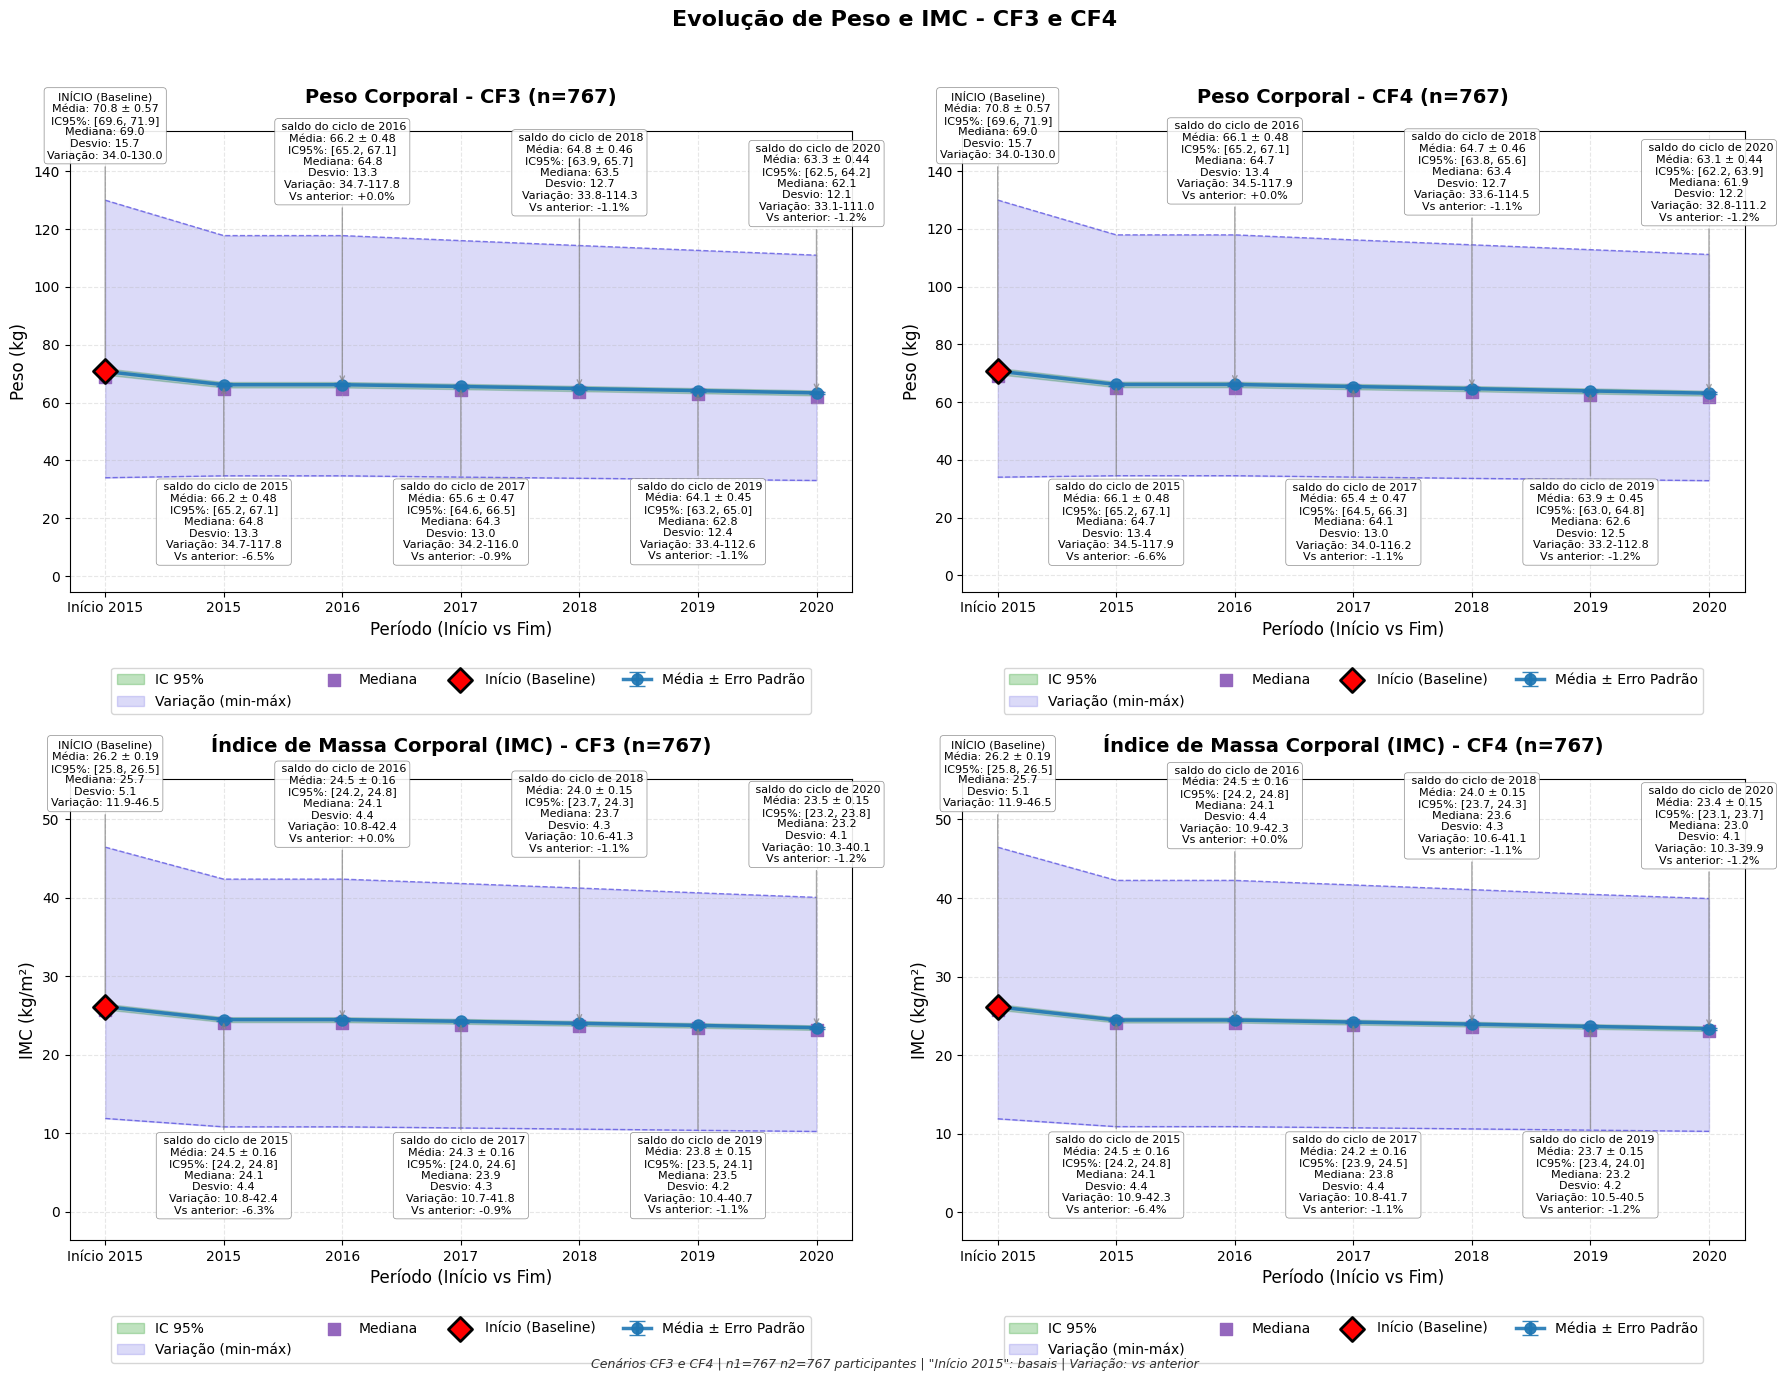

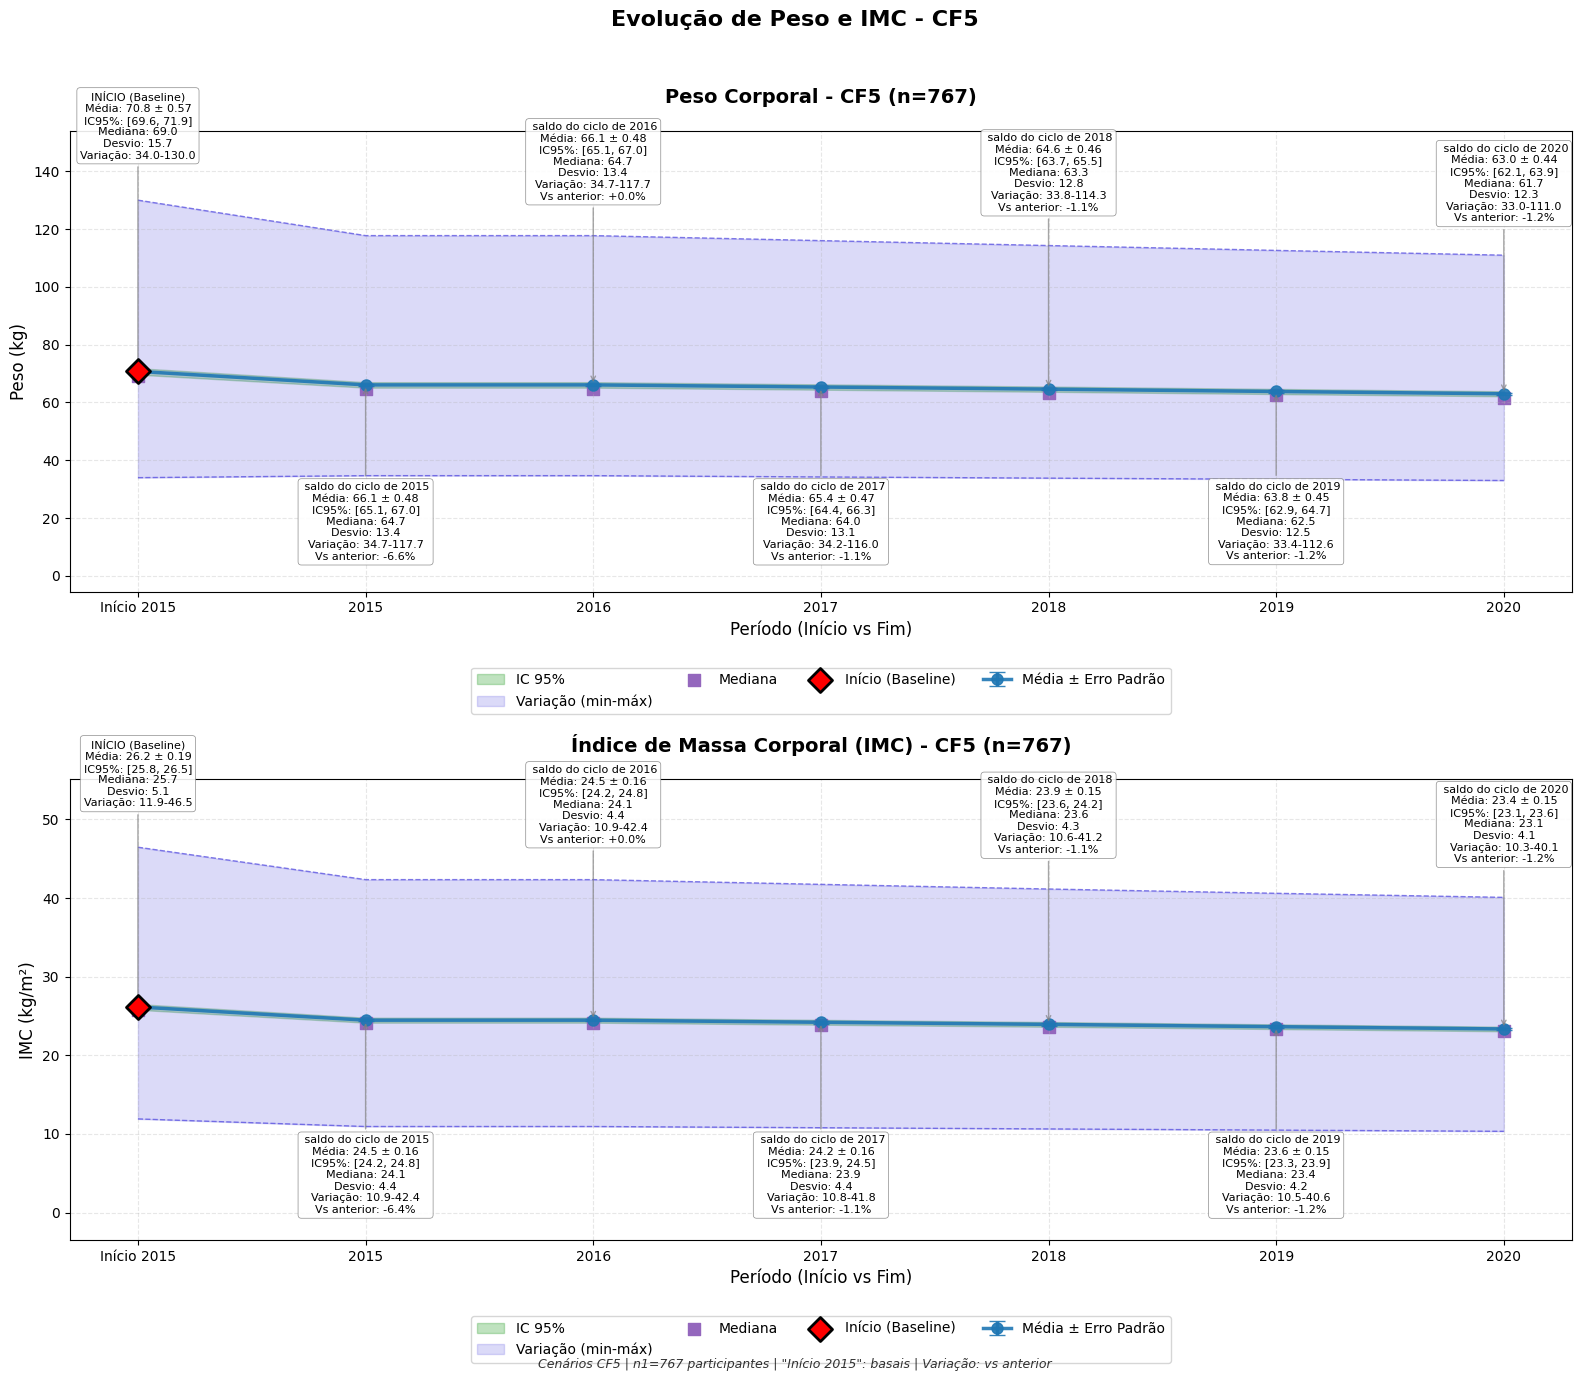

In [12]:
# importar bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

# funcao para processar  todos os cenários 
# resultados_cenario como dicionario com os dados simulados por cenário
def processar_todos_cenarios(resultados_cenarios, df_original, anos):
    semanas = 52 # numero de semanas em um ano
    resultados_df = {} # criacao de dicionarios que vai guardar os resultados por cenario
    for cenario, resultados in resultados_cenarios.items():
        df_sim = pd.concat(resultados, ignore_index=True)
        base = df_original[['id','peso','altura']].drop_duplicates().set_index('id')
        pesos, alturas = base['peso'].copy(), base['altura'].copy()
        finais = {} # armazenamento final  do peso final de  cada pessoa por ano
        # interacao de cada cenario  e resultados
        for i, ano in enumerate(anos):
            colunas = [f'semana_{j+1}' for j in range(semanas if ano==2015 else i*semanas)]
            var = df_sim.groupby('id')[colunas].mean().sum(axis=1) / 7700
            finais[ano] = pesos + var 
        # dataframe final com peso e imc  por ano 
        df = df_original[['id','altura']].drop_duplicates().set_index('id')
        df['Peso_2015_base'] = pesos
        df['IMC_2015_base'] = pesos / (df['altura']**2)
        for ano in anos:
            df[f'Peso_{ano}'] = finais[ano]
            df[f'IMC_{ano}'] = finais[ano] / (df['altura']**2)
        resultados_df[cenario] = df.reset_index()
    return resultados_df

# funcao para calculos estatisticos  do dataframe para cada ano 
def calcular_estatisticas_ano_completo(df, anos, tipo='Peso'):
    listas = [[] for _ in range(11)]  # listar para guardar  cada estatisticas
    anos_com_base = ['Início 2015'] + anos  # inclusao da linha de base  ou entrada
    for i, periodo in enumerate(anos_com_base):
        col = f'{tipo}_2015_base' if periodo == 'Início 2015' else f'{tipo}_{periodo}'
        dados = df[col].dropna()
        n, media = len(dados), dados.mean() #número de participantes e média
        ic = 1.96 * dados.sem()  # intervalo de confiança
        minimo, maximo = dados.min(), dados.max()
        amp = maximo - minimo
        pct_ic = np.sum((dados >= media-ic) & (dados <= media+ic)) / n * 100 if n > 0 else np.nan
        # calculo da porcentagem de variacao em relacao ao ano anterior 
        if periodo == 'Início 2015':
            variacao = 0
        else:
            periodo_ant = anos_com_base[i-1]
            col_ant = f'{tipo}_2015_base' if periodo_ant == 'Início 2015' else f'{tipo}_{periodo_ant}'
            dados_ant = df[col_ant].dropna()
            variacao = ((media - dados_ant.mean()) / dados_ant.mean() * 100) if len(dados_ant) > 0 else 0
        valores = [media, dados.median(), dados.std(), dados.sem(), ic, variacao,
                   minimo, maximo, amp, n, pct_ic]
        for lista, val in zip(listas, valores):
            lista.append(val)
    return map(np.array, listas)

# funcao para criar graficos via plot com as medidas estatisticas
def criar_grafico_cenario(ax, anos, estatisticas, tipo, cenario):
    cores = ['#1f77b4', '#0ecfff', '#2ca02c', '#4e46de', '#9467bd']  
    medias, medianas, desvios, erros, ic95, variacoes, minimos, maximos, amplitudes, n, _ = estatisticas
    anos_b = ['Início 2015'] + anos
    x = range(len(anos_b))
    # grafico principal com erro padrao 
    ax.errorbar(x, medias, yerr=erros, fmt='-o', capsize=6, lw=2.5, ms=8,
                color=cores[0], ecolor=cores[0], alpha=0.9, label='Média ± Erro Padrão')
    ax.fill_between(x, medias-ic95, medias+ic95, color=cores[2], alpha=0.3, label='IC 95%')
    ax.fill_between(x, minimos, maximos, color=cores[3], alpha=0.2, label='Variação (min-máx)')
    ax.plot(x, minimos, '--', color=cores[3], alpha=0.7, lw=1)
    ax.plot(x, maximos, '--', color=cores[3], alpha=0.7, lw=1)
    ax.scatter(x, medianas, marker='s', s=80, color=cores[4], label='Mediana')
    ax.scatter([0], [medias[0]], marker='D', s=150, color='red',
               edgecolors='black', lw=2, zorder=10, label='Início (Baseline)')

    unidade, titulo = ('kg', 'Peso Corporal') if tipo == 'Peso' else ('kg/m²', 'Índice de Massa Corporal (IMC)')
    ax.set_title(f'{titulo} - {cenario} (n={n[0]})', fontsize=14, fontweight='bold', pad=20)

    box = dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9,
               edgecolor="gray", lw=0.5)
    # informações estatisticas do grafico 
    for i, (x0, m, med, d, e, ic, mi, ma, amp, var) in enumerate(zip(x, medias, medianas, desvios, erros, ic95, minimos, maximos, amplitudes, variacoes)):
        txt = (f'INÍCIO (Baseline)\nMédia: {m:.1f} ± {e:.2f}\nIC95%: [{m-ic:.1f}, {m+ic:.1f}]\n'
               f'Mediana: {med:.1f}\nDesvio: {d:.1f}\nVariação: {mi:.1f}-{ma:.1f}'
               if i == 0 else
               f' saldo do ciclo de {anos_b[i]}\nMédia: {m:.1f} ± {e:.2f}\nIC95%: [{m-ic:.1f}, {m+ic:.1f}]\n'
               f'Mediana: {med:.1f}\nDesvio: {d:.1f}\nVariação: {mi:.1f}-{ma:.1f}\nVs anterior: {var:+.1f}%')
        ax.annotate(txt, xy=(x0, m),
                    xytext=(x0, ma+amp*0.15) if i % 2 == 0 else (x0, mi-amp*0.35),
                    ha='center', fontsize=8, bbox=box,
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=1))

    ax.set_xlabel('Período (Início vs Fim)', fontsize=12)
    ax.set_ylabel(f'{tipo} ({unidade})', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(anos_b)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    ax.set_ylim(minimos.min() - amplitudes.max()*0.4, maximos.max() + amplitudes.max()*0.25)

# funcao para fazer o grafico  
def g_relatorio_completo(res, anos):
    plt.style.use('default')
    plt.rcParams['font.family'] = 'DejaVu Sans'
    cores= ['#1f77b4', '#0ecfff', '#2ca02c', '#4e46de', '#9467bd']
    cenarios = ["CF1", "CF2", "CF3", "CF4", "CF5"]
    i = 0

    while i < len(cenarios):
        if cenarios[i] == "CF5":
            dfs, cs = [res[cenarios[i]]], [cenarios[i]]
            i += 1
        else:
            dfs, cs = [res[cenarios[i]], res[cenarios[i+1]]], [cenarios[i], cenarios[i+1]]
            i += 2

        n_cols = len(dfs)
        fig, axs = plt.subplots(2, n_cols, figsize=(16 + 2*(n_cols-1), 14))
        fig.suptitle(f'Evolução de Peso e IMC - {" e ".join(cs)}', fontsize=16, fontweight='bold', y=0.98)

        for j, (df, c) in enumerate(zip(dfs, cs)):
            criar_grafico_cenario(axs[0, j] if n_cols > 1 else axs[0],
                                  anos, calcular_estatisticas_ano_completo(df, anos, 'Peso'),
                                  'Peso', c)
            criar_grafico_cenario(axs[1, j] if n_cols > 1 else axs[1],
                                  anos, calcular_estatisticas_ano_completo(df, anos, 'IMC'),
                                  'IMC', c)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        fig.text(0.5, 0.01,
                 f'Cenários {" e ".join(cs)} | ' +
                 ' '.join([f"n{i+1}={len(df)}" for i, df in enumerate(dfs)]) +
                 ' participantes | "Início 2015": basais | Variação: vs anterior',
                 ha='center', fontsize=9, style='italic', alpha=0.8)
        plt.show()

# lista dos anos analisados
anos = list(range(2015, 2021))
resultados_cenarios_df = processar_todos_cenarios(resultados_cenarios, df_original, anos)
g_relatorio_completo(resultados_cenarios_df, anos)


## Visualizaçãos dos Estados Nutricionais

In [13]:
import matplotlib.pyplot as plt 
import pandas as pd
# lista de semanas que representa ano
semanas_por_ano = 52
# Lista de anos para sere calculados
anos = list(range(2015, 2021))
# Pós-Processamento: Calcula o peso por cada pessoa em cada ano, a partir das semanas simuladas
def calcular_peso_ano(df_sim, df_peso, anos, semanas_por_ano):
   # comeca  com o peso inicial de 2015
    pesos = {2015: df_peso.set_index('id')['peso']} 
    # evolui para cada ano seguinte calculando o peso acumulado
    for i, ano in enumerate(anos[1:], start=1):
        colunas = [f'semana_{j+1}' for j in range(i * semanas_por_ano)]
        # calcula a media semanal de calorias e transforma em peso
        acumulado = df_sim.groupby('id')[colunas].mean().sum(axis=1)
        # atualiza o peso somado ao inicial, convertendo  a variacao para kg
        pesos[ano] = df_peso.set_index('id')['peso'] + acumulado / 7700
    return pesos
# Junta os dados finais, calcunado peso e imc por ano
def g_resultados(df_original, df_sim, anos):
    df_peso = df_original[['id', 'peso', 'altura']].drop_duplicates()
    # calcula o peso para cada ano
    pesos_por_ano = calcular_peso_ano(df_sim, df_peso, anos, semanas_por_ano)
    # cria uma tabela final com dados unicos para cada pessoa
    df_final = df_original[['id', 'Categorias', 'altura']].drop_duplicates().set_index('id')
    # adiciona o peso e imc para cada ano
    for ano in anos:
        df_final[f'Peso_{ano}'] = pesos_por_ano[ano]
        df_final[f'IMC_{ano}'] = df_final[f'Peso_{ano}'] / (df_final['altura'] ** 2)
    return df_final.reset_index()

# Processar todos os cenários para cada cenarios
resultados_cenarios_df = {c: g_resultados(df_original, pd.concat(res_list, ignore_index=True), anos)
                          for c, res_list in resultados_cenarios.items()}

print("ok")


ok


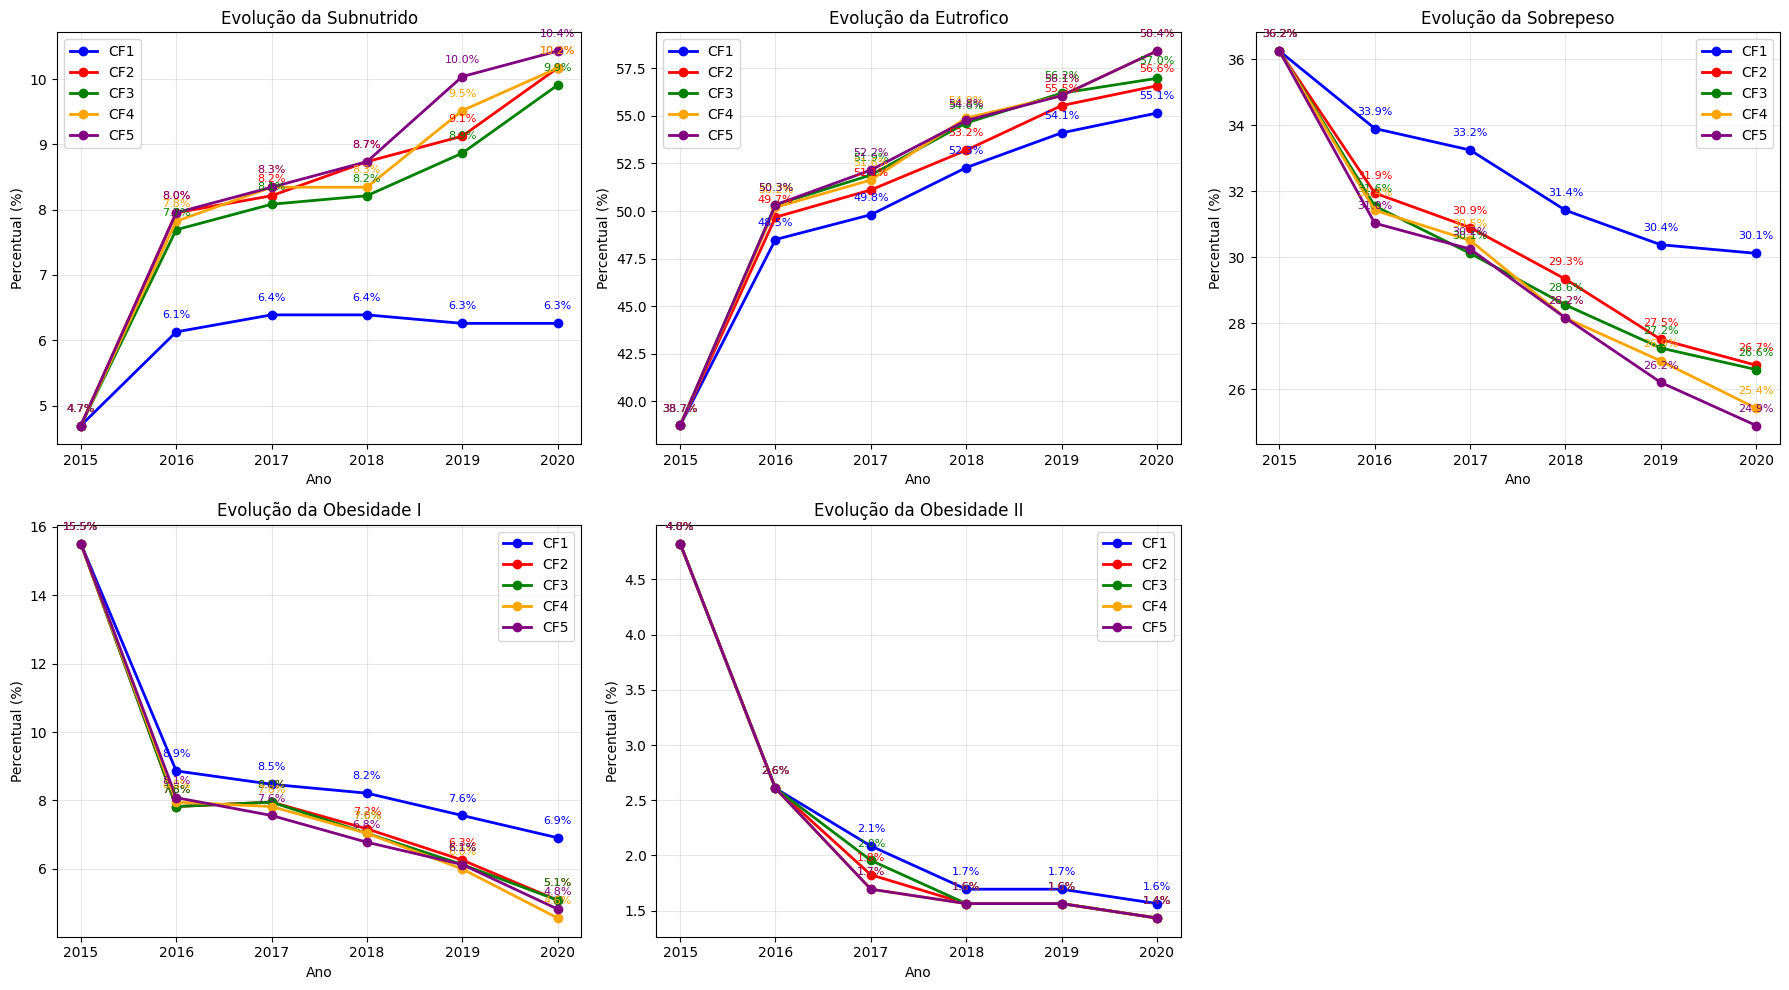

In [14]:
# funcao para classificar o IMC em categorias
def classificar_imc(imc):
    if imc < 18.5: return 'Subnutrido'
    elif imc < 25: return 'Eutrofico'
    elif imc < 30: return 'Sobrepeso'
    elif imc < 35: return 'Obesidade I'
    else: return 'Obesidade II'
# Lista de categorias do IMC
categorias = ['Subnutrido', 'Eutrofico', 'Sobrepeso', 'Obesidade I', 'Obesidade II']
# Cor para cada cenario
cores_cenarios = {'CF1': 'blue', 'CF2': 'red', 'CF3': 'green', 'CF4': 'orange', 'CF5': 'purple'}
# Figura com subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
# para cada cenario  de IMC, cria-se grafico
for idx, categoria in enumerate(categorias):
    ax = axes[idx]
    for cenario, df_final in resultados_cenarios_df.items():
        # calculas a porcentagem de pessoas por cada categoria
        percentuais = [(df_final[f'IMC_{ano}'].apply(classificar_imc) == categoria).mean() * 100
                       for ano in anos]
        #Cria-se linha do gráfico
        line = ax.plot(anos, percentuais, 'o-', linewidth=2, label=cenario, color=cores_cenarios.get(cenario, 'black'))[0]
        # porcenagem dos valores  em cada linha
        for ano, perc in zip(anos, percentuais):
            ax.annotate(f'{perc:.1f}%', (ano, perc), xytext=(0,10), textcoords="offset points", ha='center', fontsize=8, color=line.get_color())
    ax.set_title(f'Evolução da {categoria}')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Percentual (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(anos)


for idx in range(len(categorias), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [15]:
df_final = resultados_cenarios_df['CF1']
(df_final[[f'IMC_{ano}' for ano in anos]] > 35).sum()


IMC_2015    37
IMC_2016    20
IMC_2017    16
IMC_2018    13
IMC_2019    13
IMC_2020    12
dtype: int64

# visualizacao em dados  geograficos

In [16]:
import pandas as pd
import warnings

warnings.simplefilter("ignore", UnicodeWarning)

df = pd.read_stata(r"C:\Users\vimed\Downloads\Banco_ISA_AF_Ambiente_Vinicius (5).dta")

df = df.filter([
    'id_original', 'N_domicilio',
    'lat2015', 'long2015', 'lat2020', 'long2020'
])

In [17]:
import pandas as pd
import numpy as np

# definiçpão de espaço temporal via 
anos = list(range(2015, 2021))  # listagem em numero de anos
semanas_por_ano = 52 # constante em semana 

# funcao  para processar todos os cenarios
def processar_todos_cenarios(resultados_cenarios, df_original, anos):
    resultados_cenarios_df = {}

    # colunas relacionados a localizacoes geograficas
    df_geo = df_original[['id', 'lat2015', 'long2015', 'lat2020', 'long2020']].drop_duplicates().set_index('id')

    for cenario, results in resultados_cenarios.items():
        #  Juntar todos os dados  simulados  desses cenarios
        df_simulacao = pd.concat(results, ignore_index=True)
        
        # peso ,id e altura de individuo  aproximados por pessoa
        df_peso_inicial = df_original[['id','peso','altura']].drop_duplicates().set_index('id')
        
        pesos_finais = {}
        for ano_idx, ano in enumerate(anos):
            # listas  com os nomes das colunas relacionados as semanas
            colunas_semana = [f'semana_{i+1}' for i in range(semanas_por_ano)] if ano == 2015 else [f'semana_{i+1}' for i in range(ano_idx*semanas_por_ano)]
            
            # Calcular peso final 
            pesos_finais[ano] = df_peso_inicial['peso'] + df_simulacao.groupby('id')[colunas_semana].mean().sum(axis=1)/7700
        
        # Criar DataFrame final com altura e coordenadas
        df_final = df_peso_inicial[['altura']].join(df_geo)
        
        # Inclusao de  de peso e imc por ano 
        for ano in anos:
            df_final[f'Peso_{ano}'] = pesos_finais[ano]
            df_final[f'IMC_{ano}'] = pesos_finais[ano] / (df_final['altura']**2)
        
        # Resetar índice para merge compatível
        resultados_cenarios_df[cenario] = df_final.reset_index()
    
    return resultados_cenarios_df

# processamento dos cenarios
resultados_cenarios_df = processar_todos_cenarios(resultados_cenarios, df_original, anos)


df = df_original.filter([
    'id', 'N_domicilio', 'lat2015', 'long2015', 'lat2020', 'long2020'
]).rename(columns={'id':'id_original'})

# funcao de todos os cenarios
cenarios = ['CF1', 'CF2', 'CF3', 'CF4', 'CF5']
dfs_merged = {}

for cf in cenarios:
    df_cenario = resultados_cenarios_df[cf].copy()
    
    # garantir  que serao feitos o merge sejam o "id_original"
    if 'id' in df_cenario.columns:
        df_cenario = df_cenario.rename(columns={'id':'id_original'})
    
    # juntar as tabelas com  os dados  cenarios
    df_merge = df.merge(df_cenario, on='id_original', how='left')
    
    # guardar resultados no dicionario 
    dfs_merged[cf] = df_merge




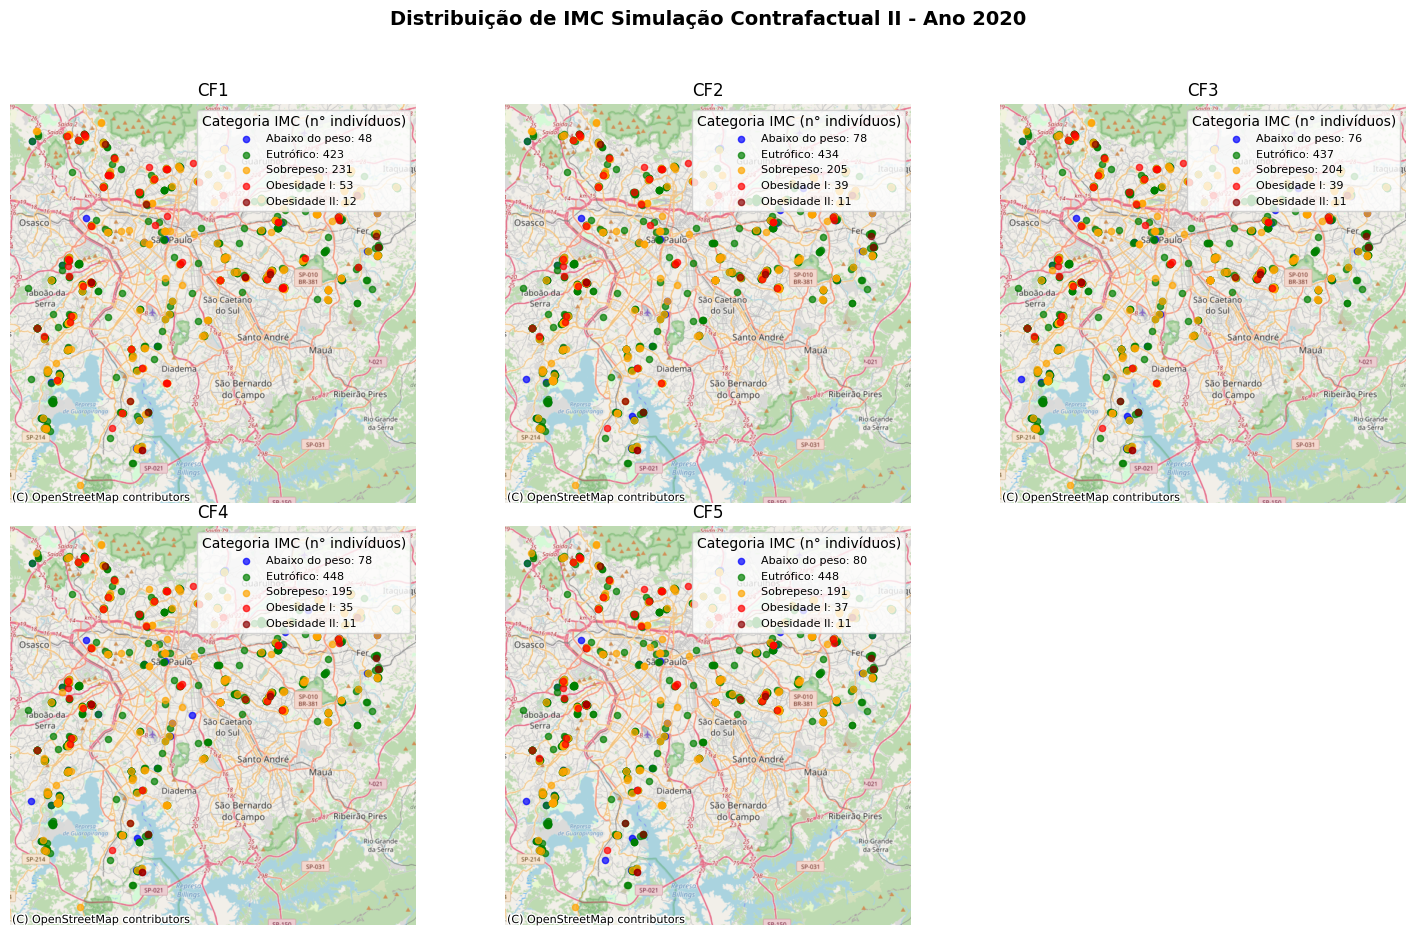

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
# paleta de cores
cores = {
    "Abaixo do peso": "blue",
    "Eutrófico": "green",
    "Sobrepeso": "orange",
    "Obesidade I": "red",
    "Obesidade II": "darkred"
}

anos_ref = 2020  # ano de referencia
cenarios = list(resultados_cenarios_df.keys())
n_cenarios = len(cenarios) # quantifacacao de cenario 

n_col = 3 # numero de colunas
n_row = 2 # numero  linhas
fig, axs = plt.subplots(n_row, n_col, figsize=(5*n_col, 5*n_row))
axs = axs.flatten()
# loop para plotagem de cada cenario 
for i, cenario in enumerate(cenarios):
    df_map = resultados_cenarios_df[cenario].dropna(subset=[f'IMC_{anos_ref}']).copy()
    # funcao para classifcar os imc
    def classificar_imc(imc):
        if imc < 18.5: return "Abaixo do peso"
        elif 18.5 <= imc < 25: return "Eutrófico"
        elif 25 <= imc < 30: return "Sobrepeso"
        elif 30 <= imc < 35: return "Obesidade I"
        else: return "Obesidade II"
    # aplicar a funcao  em  coluna
    df_map["categoria_imc"] = df_map[f'IMC_{anos_ref}'].apply(classificar_imc)
     # conversao de  de um geodataframe com pontos geograficos
    gdf = gpd.GeoDataFrame(
        df_map,
        geometry=[Point(xy) for xy in zip(df_map["long2020"], df_map["lat2020"])],
        crs="EPSG:4326"
    )
    gdf = gdf.to_crs(epsg=3857)

    ax = axs[i]
    legendas = []
 # plotar individuos  de ada categoria de imc 
    for categoria, cor in cores.items():
        subset = gdf[gdf["categoria_imc"] == categoria]
        if not subset.empty:
            subset.plot(ax=ax, markersize=20, color=cor, alpha=0.7)
            legendas.append(f"{categoria}: {len(subset)}")
    #  o open streep map sobre
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(f"{cenario}", fontsize=12)
    ax.legend(legendas, title="Categoria IMC (n° indivíduos)", loc='upper right', fontsize=8)

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle(f"Distribuição de IMC Simulação Contrafactual II - Ano {anos_ref}", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


# Classes Mais Impactas

In [19]:
import pandas as pd

df_bairros = pd.read_csv(r"C:/Users/vimed/Downloads/Dados_Geograficos_padrao.csv")

In [20]:
df_bairros = df_bairros.loc[:, ~df_bairros.columns.str.endswith(('_x', '_y'))]


In [ ]:
import pandas as pd
import numpy as np

# funcao para classificar o imc do individuos
def classificar_imc(imc):
    if imc < 18.5:
        return "Abaixo do peso"
    elif 18.5 <= imc < 25:
        return "Eutrófico"
    elif 25 <= imc < 30:
        return "Sobrepeso"
    elif 30 <= imc < 35:
        return "Obesidade I"
    else:
        return "Obesidade II"

# loop para processar cada cenario 
dfs_bairros = {}  # dicionario  para armazenar os resultados 

for cenario in cenarios:
    print(f"Processando cenário: {cenario}") ## callback para verificacao 

    # Copia do dataframe
    df = resultados_cenarios_df[cenario].copy()

    # garante que  existe o id coprrespondete
    if 'id' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'id'})

    #  id validos
    df = df.dropna(subset=['IMC_2020']).copy()

    # classificao de imc 2020
    df['categoria_imc_2020'] = df['IMC_2020'].apply(classificar_imc)

    #  join  baseado no id 
    df_join = df_bairros.merge(
        df[['id', 'IMC_2020', 'categoria_imc_2020']],
        on='id',
        how='left'
    )

  
    dfs_bairros[cenario] = df_join

print("feito")



Gráficos para CF1...


C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

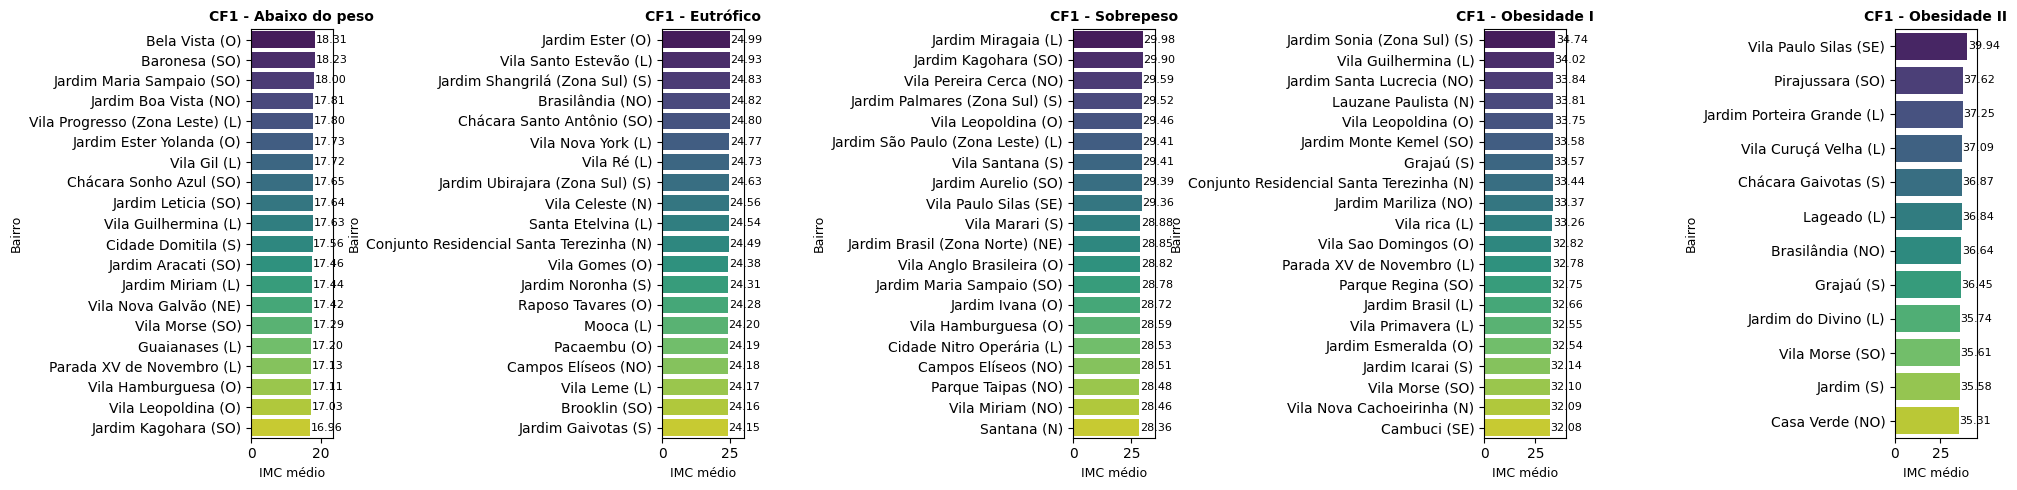


Gráficos para CF2...


C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

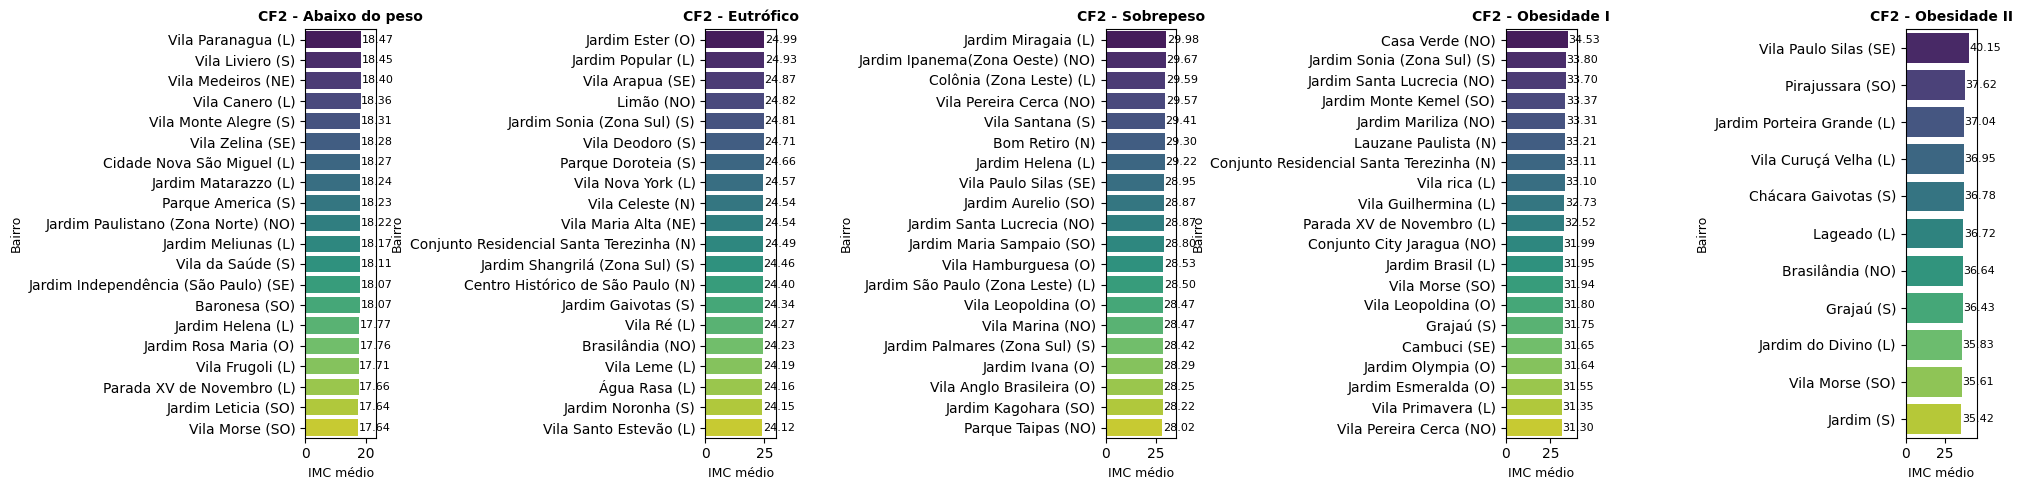


Gráficos para CF3...


C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

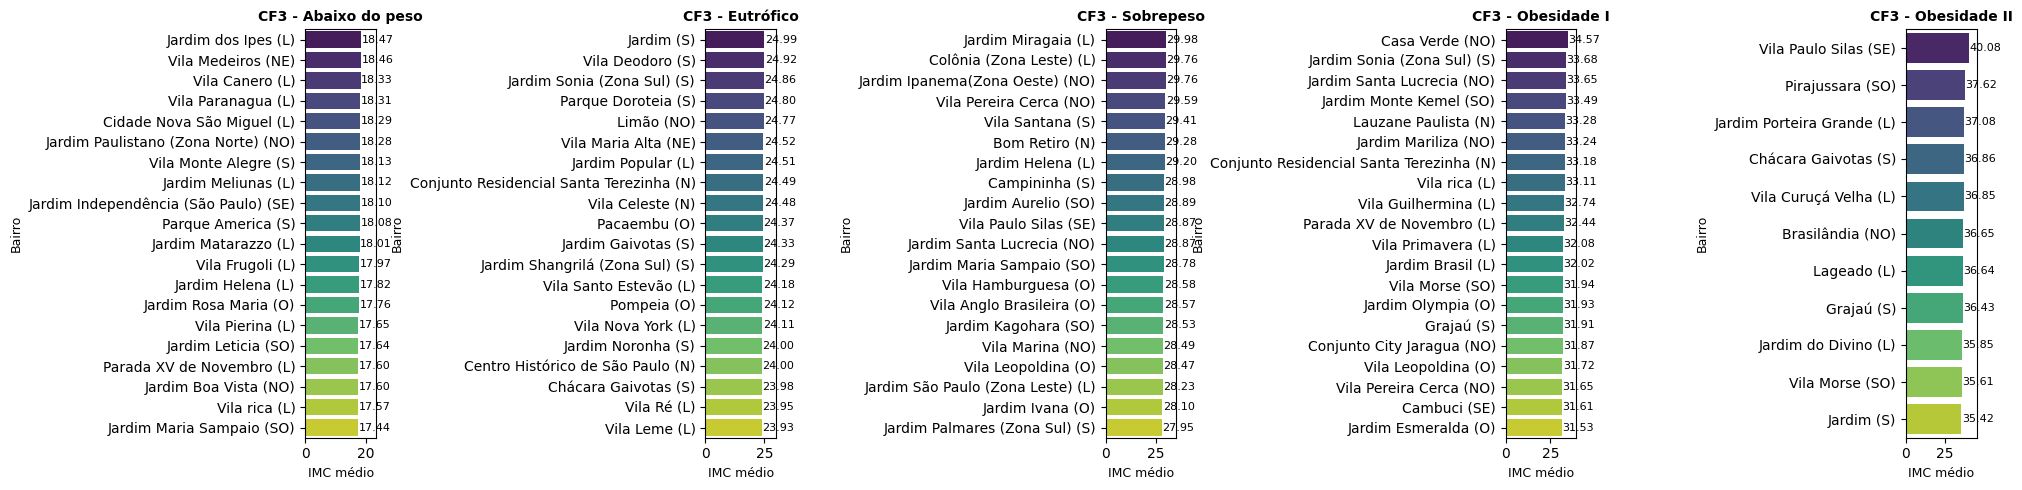


Gráficos para CF4...


C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

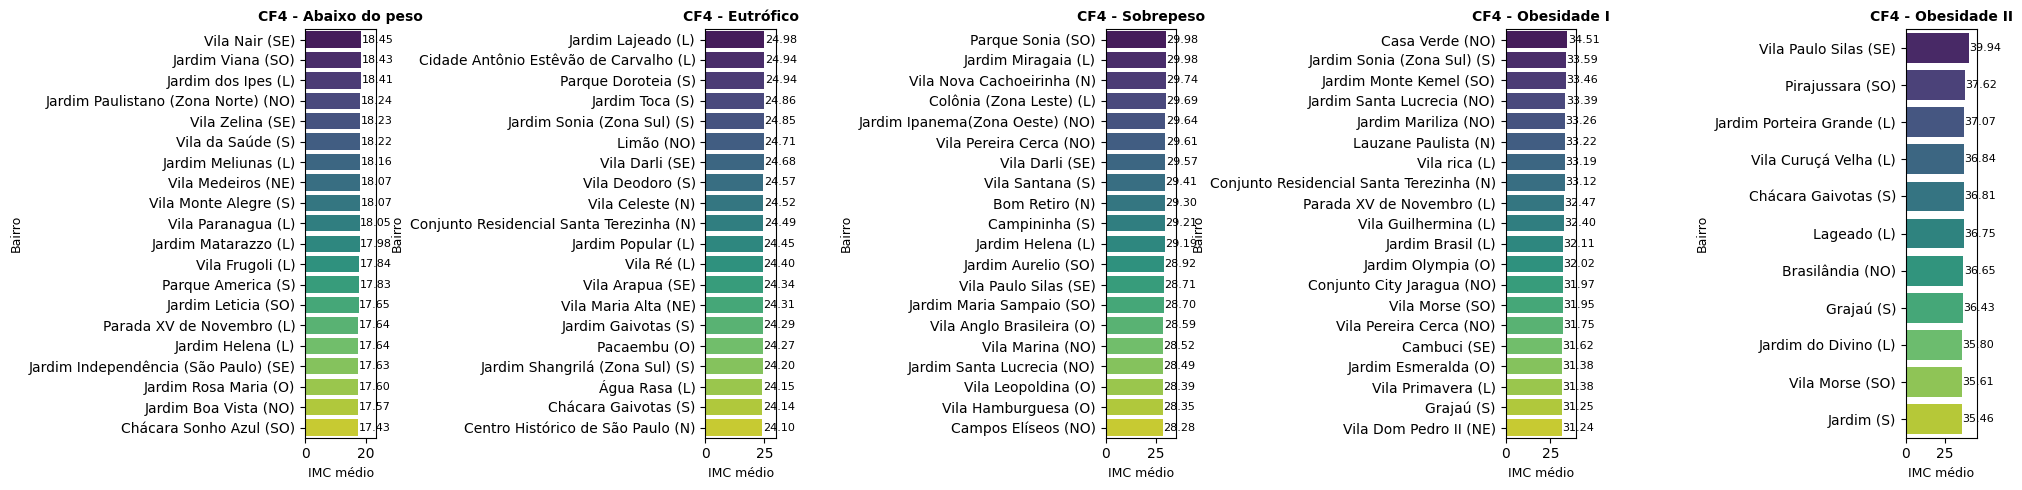


Gráficos para CF5...


C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_64772\1969177492.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

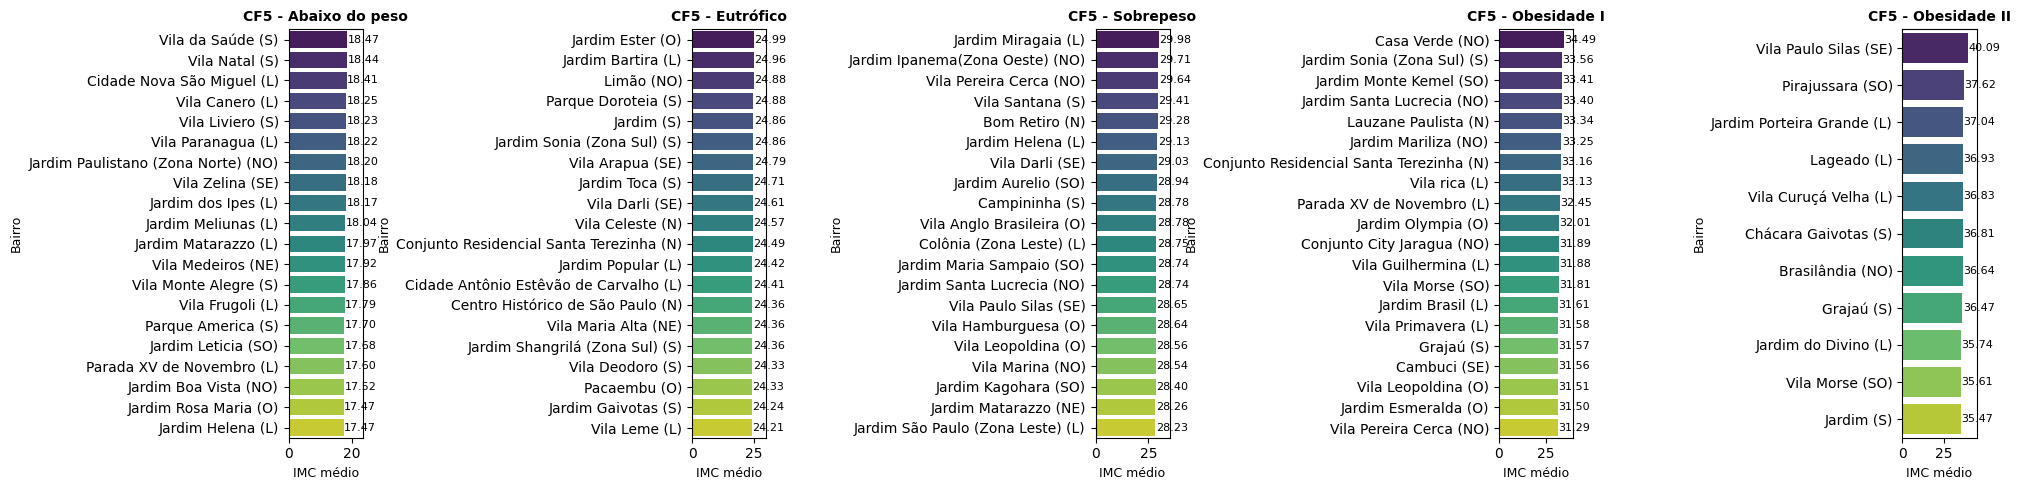

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# funcao para poder plotar a medi do imc dos 20 top bairros com os imc altos 
def plot_top20_bairros_imc_medio(dfs_bairros, categorias_imc):
 
    for cenario, df in dfs_bairros.items():
        print(f"\nGráficos para {cenario}...")

        #  agregação  de imc medio por bairro  categoria  e regiao 
        df_agg = (
            df.groupby(["categoria_imc_2020", "bairro", "regiao_cardinal"], dropna=False)["IMC_2020"]
            .mean()
            .reset_index(name="imc_medio")
        )

        #  concatenar  o nome da regiao 
        df_agg["bairro_regiao"] = df_agg.apply(
            lambda x: f"{x['bairro']} ({x['regiao_cardinal']})" if pd.notnull(x['regiao_cardinal']) else x['bairro'],
            axis=1
        )
        #definicao das categorias  do subplots
        n_categorias = len(categorias_imc)
        n_colunas = 5
        n_linhas = math.ceil(n_categorias / n_colunas)

        fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(20, 5 * n_linhas))
        axs = axs.flatten()

        for i, categoria in enumerate(categorias_imc):
            ax = axs[i]
            df_cat = (
                df_agg[df_agg["categoria_imc_2020"] == categoria]
                .sort_values("imc_medio", ascending=False)
                .head(20)
            )

            sns.barplot(
                data=df_cat,
                y="bairro_regiao",
                x="imc_medio",
                palette="viridis",
                ax=ax
            )

            ax.set_title(f"{cenario} - {categoria}", fontsize=10, fontweight="bold")
            ax.set_xlabel("IMC médio", fontsize=9)
            ax.set_ylabel("Bairro", fontsize=9)

            for j, v in enumerate(df_cat["imc_medio"]):
                ax.text(v + 0.2, j, f"{v:.2f}", color="black", va="center", fontsize=8)

            max_val = df_cat["imc_medio"].max()
            ax.set_xlim(0, max_val + 5)

        for k in range(i + 1, len(axs)):
            axs[k].set_visible(False)

        plt.tight_layout()
        plt.show()


# Categorias  do IMC
categorias_imc = ["Abaixo do peso", "Eutrófico", "Sobrepeso", "Obesidade I", "Obesidade II"]

# Funcao 
plot_top20_bairros_imc_medio(dfs_bairros, categorias_imc)